In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import seaborn as sns
# 数据加载
df = pd.read_csv('data_heart.csv')
df

,Age,Gender,CpType,RestingBP,SerumChol,FBG,RestingECG,HRmax,Angina,StDescent,StSlope,GaNum,Thalassemia,Result
0,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,normal,0.0
1,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,normal,0.0
2,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,normal,0.0
3,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,normal,1.0
4,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,normal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,52.0,1.0,1.0,118.0,186.0,0.0,2.0,190.0,0.0,0.0,2.0,0.0,fixed,0.0
296,43.0,0.0,4.0,132.0,341.0,1.0,2.0,136.0,1.0,3.0,2.0,0.0,reversible,1.0
297,65.0,1.0,4.0,135.0,254.0,0.0,2.0,127.0,0.0,2.8,2.0,1.0,reversible,1.0
298,48.0,1.0,4.0,130.0,256.0,1.0,2.0,150.0,1.0,0.0,1.0,2.0,reversible,1.0


### 数据分析

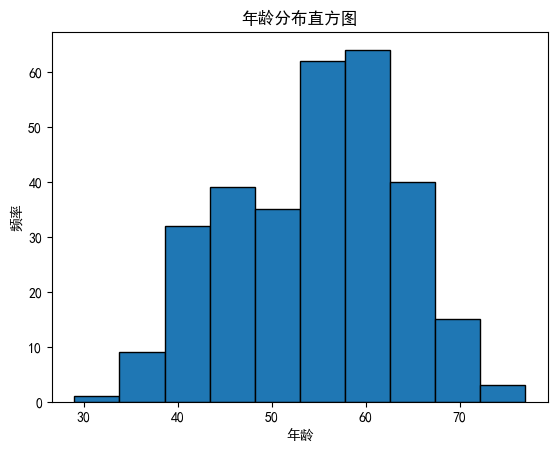

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
# 总分数据
total_scores = df['Age']

# 绘制直方图
plt.hist(total_scores, bins=10, edgecolor='black')
plt.title('年龄分布直方图')
plt.xlabel('年龄')
plt.ylabel('频率')
plt.savefig('1.png', dpi=600) 
plt.show()

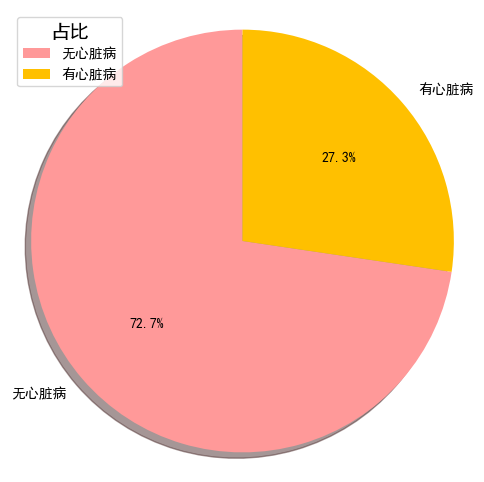

In [3]:
labels = ['无心脏病','有心脏病']
# 定义数据
sizes = [df['Result'].value_counts()[0],df['Result'].value_counts()[1]]
colors = ['#ff9999', '#ffc000']
explode = (0, 0)  # 突出显示第二个部分

# 绘制饼图
fig, ax = plt.subplots(figsize=(6, 6))  # 设置图形大小为6x6英寸
ax.pie(sizes, explode=explode, labels=labels, 
       colors=colors, autopct='%1.1f%%',shadow=True, startangle=90)
ax.axis('equal')  # 设置为等比例圆形

# 添加图例
legend = ax.legend(title="占比", loc='upper left', bbox_to_anchor=(0, 1))
plt.setp(legend.get_title(), fontsize=14, fontweight='bold')  # 设置图例标题字体大小和加粗
plt.savefig('2.png', dpi=600) 
plt.show()

Gender
1.0: 202
0.0: 98
CpType
4.0: 140
3.0: 84
2.0: 49
1.0: 23
0.0: 4
FBG
0.0: 256
1.0: 44
RestingECG
0.0: 149
2.0: 143
1.0: 8
Angina
0.0: 203
1.0: 97
Thalassemia
normal: 167
reversible: 114
fixed: 17
1: 1
2: 1


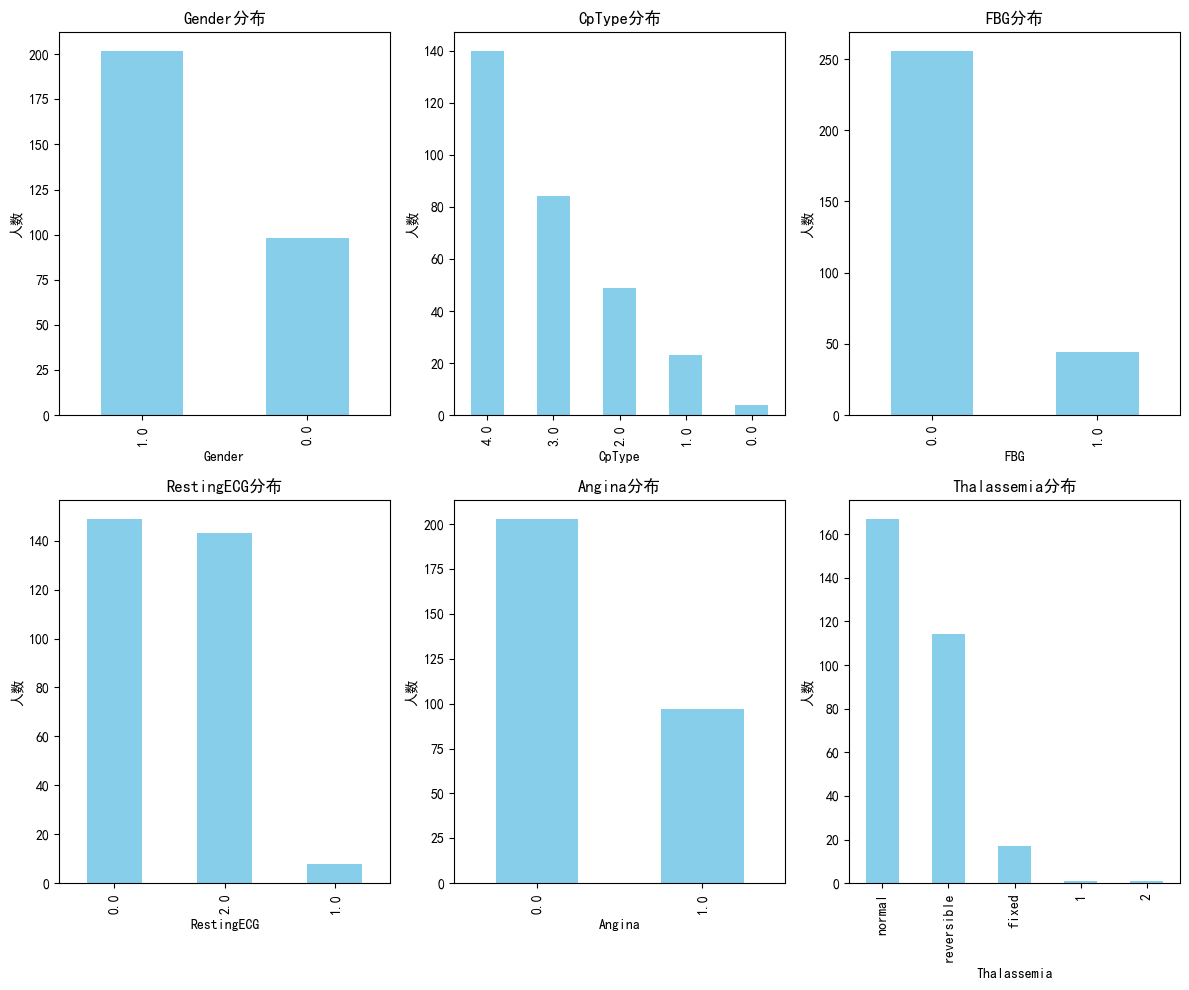

In [5]:
# 选择需要分析的字段
selected_columns =['Gender','CpType','FBG','RestingECG','Angina','Thalassemia']

# 创建多子图
plt.figure(figsize=(12, 10))

for i, column in enumerate(selected_columns, 1):
    print(column)
    counts = df[column].value_counts()
    for label, count in zip(counts.index, counts):
        print(f'{label}: {count}')
    plt.subplot(2, 3, i)
    
    df[column].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'{column}分布')
    plt.xlabel(column)
    plt.ylabel('人数')

plt.tight_layout()
plt.savefig('3.png', dpi=600) 
plt.show()


### one-hot编码

In [6]:
df_encoded = pd.get_dummies(df, columns=['CpType', 'RestingECG', 'Thalassemia'])
df_encoded

,Age,Gender,RestingBP,SerumChol,FBG,HRmax,Angina,StDescent,StSlope,GaNum,...,CpType_3.0,CpType_4.0,RestingECG_0.0,RestingECG_1.0,RestingECG_2.0,Thalassemia_1,Thalassemia_2,Thalassemia_fixed,Thalassemia_normal,Thalassemia_reversible
0,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,3.0,0.0,...,1,0,1,0,0,0,0,0,1,0
1,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,1.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2,56.0,1.0,120.0,236.0,0.0,178.0,0.0,0.8,1.0,0.0,...,0,0,1,0,0,0,0,0,1,0
3,62.0,0.0,140.0,268.0,0.0,160.0,0.0,3.6,3.0,2.0,...,0,1,0,0,1,0,0,0,1,0
4,57.0,0.0,120.0,354.0,0.0,163.0,1.0,0.6,1.0,0.0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,52.0,1.0,118.0,186.0,0.0,190.0,0.0,0.0,2.0,0.0,...,0,0,0,0,1,0,0,1,0,0
296,43.0,0.0,132.0,341.0,1.0,136.0,1.0,3.0,2.0,0.0,...,0,1,0,0,1,0,0,0,0,1
297,65.0,1.0,135.0,254.0,0.0,127.0,0.0,2.8,2.0,1.0,...,0,1,0,0,1,0,0,0,0,1
298,48.0,1.0,130.0,256.0,1.0,150.0,1.0,0.0,1.0,2.0,...,0,1,0,0,1,0,0,0,0,1


### 描述性分析

In [7]:
df_encoded.describe()

,Age,Gender,RestingBP,SerumChol,FBG,HRmax,Angina,StDescent,StSlope,GaNum,...,CpType_3.0,CpType_4.0,RestingECG_0.0,RestingECG_1.0,RestingECG_2.0,Thalassemia_1,Thalassemia_2,Thalassemia_fixed,Thalassemia_normal,Thalassemia_reversible
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,54.483333,0.673333,131.686667,246.520000,0.146667,149.396667,0.323333,1.04700,1.583333,0.673333,...,0.280000,0.466667,0.496667,0.026667,0.476667,0.003333,0.003333,0.056667,0.556667,0.380000
std,8.990689,0.469778,17.732549,52.371674,0.354364,23.136775,0.468530,1.16491,0.614530,0.928887,...,0.449749,0.499721,0.500824,0.161376,0.500290,0.057735,0.057735,0.231591,0.497609,0.486197
min,29.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,120.000000,211.000000,0.000000,132.750000,0.000000,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,130.000000,241.500000,0.000000,152.500000,0.000000,0.80000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,140.000000,275.000000,0.000000,166.000000,1.000000,1.60000,2.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,77.000000,1.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.20000,3.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 箱型图的绘制

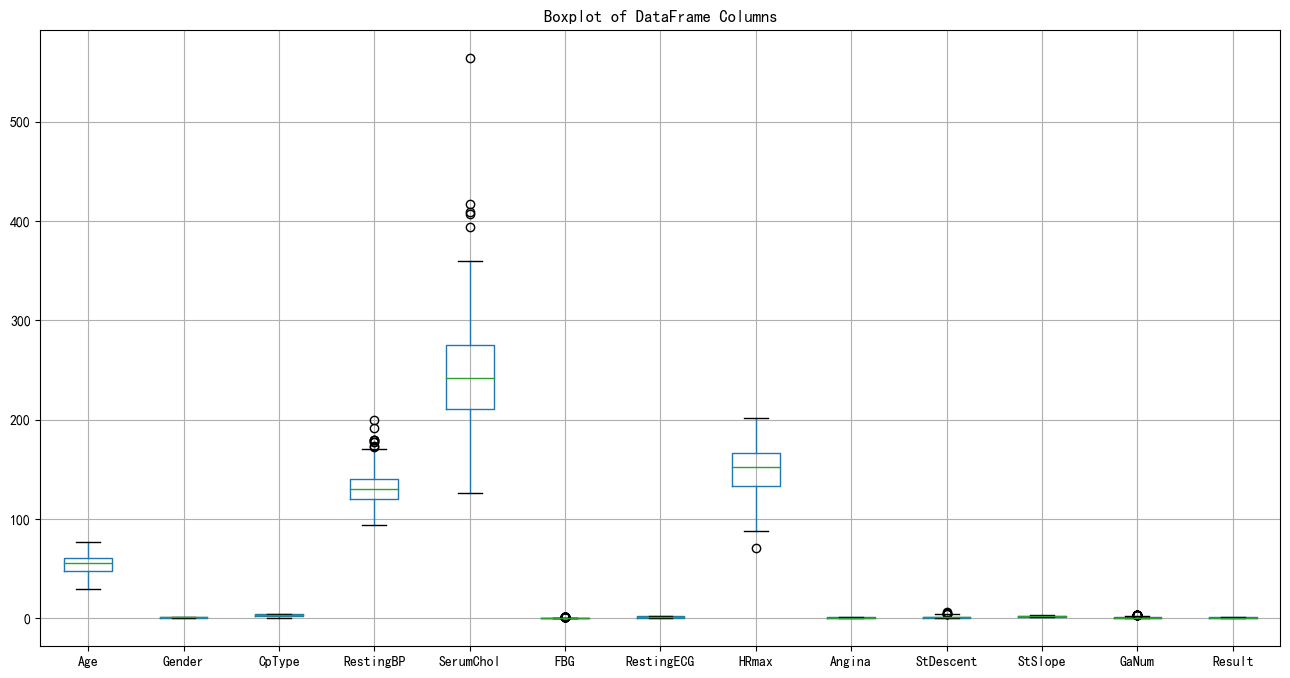

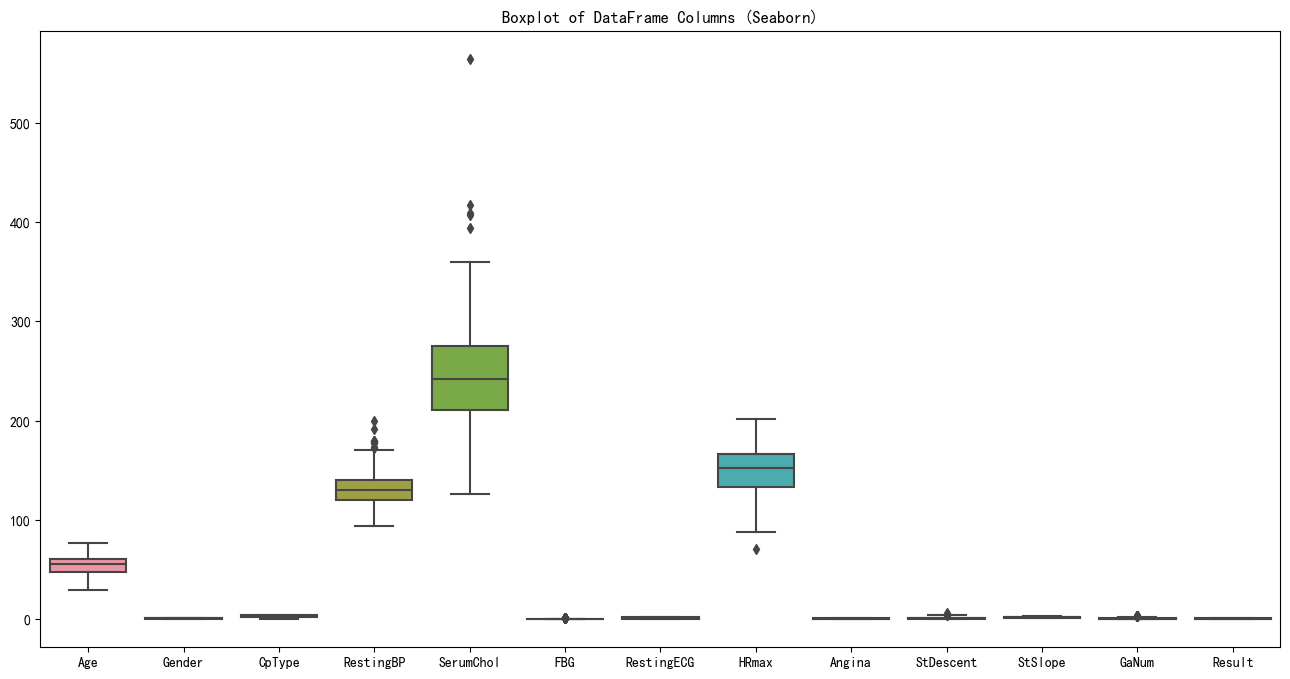

In [8]:
# 使用matplotlib绘制箱型图
plt.figure(figsize=(16, 8))
df.boxplot()
plt.title('Boxplot of DataFrame Columns')
plt.savefig('4.png', dpi=600) 
plt.show()

# 或者，使用seaborn绘制箱型图
plt.figure(figsize=(16, 8))
sns.boxplot(data=df)
plt.title('Boxplot of DataFrame Columns (Seaborn)')
plt.savefig('5.png', dpi=600) 
plt.show()

### 相关性热力图分析

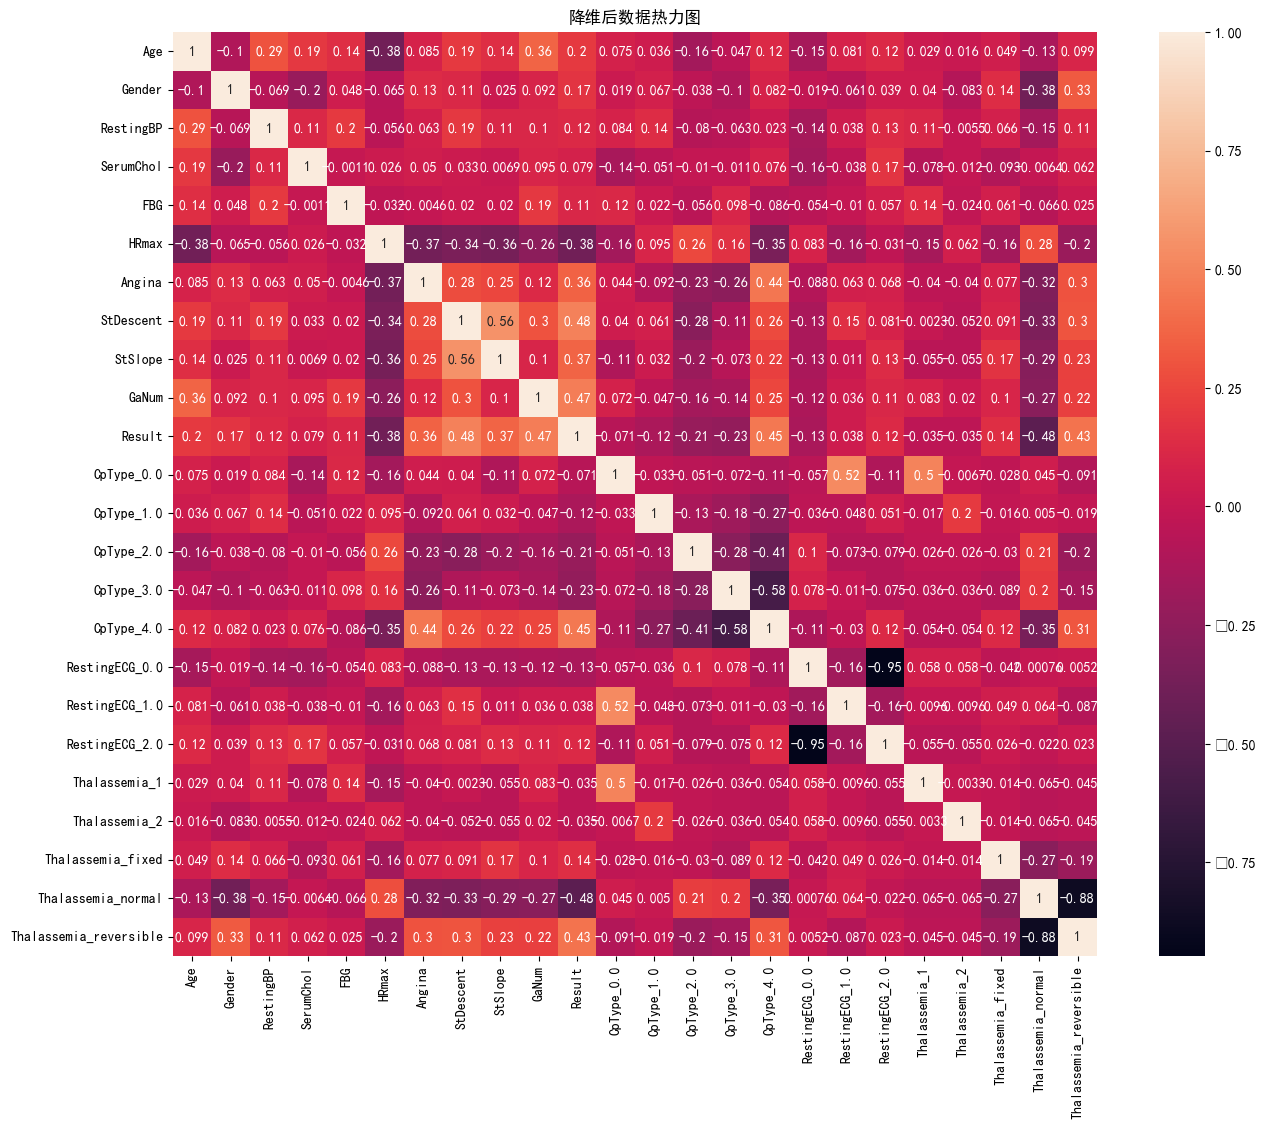

In [9]:
corr = df_encoded.corr()
f, ax =plt.subplots(figsize=(16,12))
plt.title("降维后数据热力图")
sns.heatmap(corr,
           vmax = 1.0,# 最大值
           square = True,# 方形
           linecolor = 'k',
           annot=True)
plt.savefig('6.png', dpi=600) 
plt.show()

In [19]:
#df_encoded.to_excel('relitu.xlsx',index=None)

### 定义评价模型方法且划分数据集

In [10]:
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n")

In [11]:
# 划分特征和目标变量
X = df_encoded.drop('Result', axis=1)
y = df_encoded['Result']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Age,Gender,RestingBP,SerumChol,FBG,HRmax,Angina,StDescent,StSlope,GaNum,...,CpType_3.0,CpType_4.0,RestingECG_0.0,RestingECG_1.0,RestingECG_2.0,Thalassemia_1,Thalassemia_2,Thalassemia_fixed,Thalassemia_normal,Thalassemia_reversible
232,67.0,1.0,152.0,212.0,0.0,150.0,0.0,0.8,2.0,0.0,...,1,0,0,0,1,0,0,0,0,1
59,62.0,1.0,130.0,231.0,0.0,146.0,0.0,1.8,2.0,3.0,...,1,0,1,0,0,0,0,0,0,1
6,53.0,1.0,140.0,203.0,1.0,155.0,1.0,3.1,3.0,0.0,...,0,1,0,0,1,0,0,0,0,1
185,41.0,0.0,126.0,306.0,0.0,163.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,1,0
173,66.0,1.0,112.0,212.0,0.0,132.0,1.0,0.1,1.0,1.0,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,60.0,0.0,120.0,178.0,1.0,96.0,0.0,0.0,1.0,0.0,...,1,0,1,0,0,0,0,0,1,0
71,45.0,0.0,130.0,234.0,0.0,175.0,0.0,0.6,2.0,0.0,...,0,0,0,0,1,0,0,0,1,0
106,46.0,1.0,101.0,197.0,1.0,156.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,1
270,46.0,0.0,142.0,177.0,0.0,160.0,1.0,1.4,3.0,0.0,...,1,0,0,0,1,0,0,0,1,0


### 模型的构建与训练

In [12]:
import pickle

# 构建模型
lgbm_model = LGBMClassifier()

xgb_model = XGBClassifier()

lr_model = LogisticRegression()


# 投票融合模型
voting_model = VotingClassifier(estimators=[('lgbm', lgbm_model), ('xgb', xgb_model), ('lr', lr_model)], voting='hard')

# 训练模型
lgbm_model.fit(X_train, y_train)

xgb_model.fit(X_train,y_train)

lr_model.fit(X_train, y_train)

voting_model.fit(X_train, y_train)

with open('model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)

# 预测
lgbm_pred = lgbm_model.predict(X_test)

xgb_pred = xgb_model.predict(X_test)

lr_pred = lr_model.predict(X_test)

voting_pred = voting_model.predict(X_test)

voting_pred

[LightGBM] [Info] Number of positive: 64, number of negative: 176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 240, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266667 -> initscore=-1.011601
[LightGBM] [Info] Start training from score -1.011601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0.])

### 评估模型

In [13]:
# 评估单个模型
evaluate_model(y_test, lgbm_pred, "LightGBM")
evaluate_model(y_test, xgb_pred, "XGBoost")
evaluate_model(y_test, lr_pred, "Logistic Regression")

# 评估投票融合模型
evaluate_model(y_test, voting_pred, "Voting Ensemble")

LightGBM Metrics:
Accuracy: 0.9167
Recall: 0.7222
Precision: 1.0000
F1 Score: 0.8387


XGBoost Metrics:
Accuracy: 0.9167
Recall: 0.7222
Precision: 1.0000
F1 Score: 0.8387


Logistic Regression Metrics:
Accuracy: 0.8833
Recall: 0.6667
Precision: 0.9231
F1 Score: 0.7742


Voting Ensemble Metrics:
Accuracy: 0.9333
Recall: 0.7778
Precision: 1.0000
F1 Score: 0.8750




### 可视化评价指标

In [14]:
import numpy as np

# 模型评估指标
models = ["LightGBM", "XGBoost", "Logistic Regression", "Voting Ensemble"]
accuracy_scores = [accuracy_score(y_test, lgbm_pred), accuracy_score(y_test, xgb_pred),
                   accuracy_score(y_test, lr_pred), accuracy_score(y_test, voting_pred)]

recall_scores = [recall_score(y_test, lgbm_pred), recall_score(y_test, xgb_pred),
                 recall_score(y_test, lr_pred), recall_score(y_test, voting_pred)]

precision_scores = [precision_score(y_test, lgbm_pred), precision_score(y_test, xgb_pred),
                    precision_score(y_test, lr_pred), precision_score(y_test, voting_pred)]

f1_scores = [f1_score(y_test, lgbm_pred), f1_score(y_test, xgb_pred),
             f1_score(y_test, lr_pred), f1_score(y_test, voting_pred)]

# 绘制柱状图
bar_width = 0.4
index = np.arange(len(models))

plt.figure(figsize=(16, 12),dpi=800)

# Accuracy
plt.subplot(2, 2, 1)
plt.bar(index, accuracy_scores, bar_width, color='b', alpha=0.7)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Comparison of Accuracy for Different Models', fontsize=16)
plt.xticks(index, models)
plt.ylim(0.6, 1.05)
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# Recall
plt.subplot(2, 2, 2)
plt.bar(index, recall_scores, bar_width, color='g', alpha=0.7)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.title('Comparison of Recall for Different Models', fontsize=16)
plt.xticks(index, models)
plt.ylim(0.6, 1.05)
for i, v in enumerate(recall_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# Precision
plt.subplot(2, 2, 3)
plt.bar(index, precision_scores, bar_width, color='r', alpha=0.7)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Comparison of Precision for Different Models', fontsize=16)
plt.xticks(index, models)
plt.ylim(0.6, 1.05)
for i, v in enumerate(precision_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# F1 Score
plt.subplot(2, 2, 4)
plt.bar(index, f1_scores, bar_width, color='orange', alpha=0.7)
plt.xlabel('Models', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.title('Comparison of F1 Score for Different Models', fontsize=16)
plt.xticks(index, models)
plt.ylim(0.6, 1.05)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('7.png', dpi=600) 
plt.show()

## 系统页面的设计与实现

D:\anaconda\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
C:\Users\h1516\AppData\Local\Temp\ipykernel_28464\439987792.py:564: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (column, value) in enumerate(selected_row.iteritems()):
C:\Users\h1516\AppData\Local\Temp\ipykernel_28464\439987792.py:564: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (column, value) in enumerate(selected_row.iteritems()):
C:\Users\h1516\AppData\Local\Temp\ipykernel_28464\439987792.py:564: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (column, value) in enumerate(selected_row.iteritems()):


SystemExit: 0

C:\Users\h1516\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


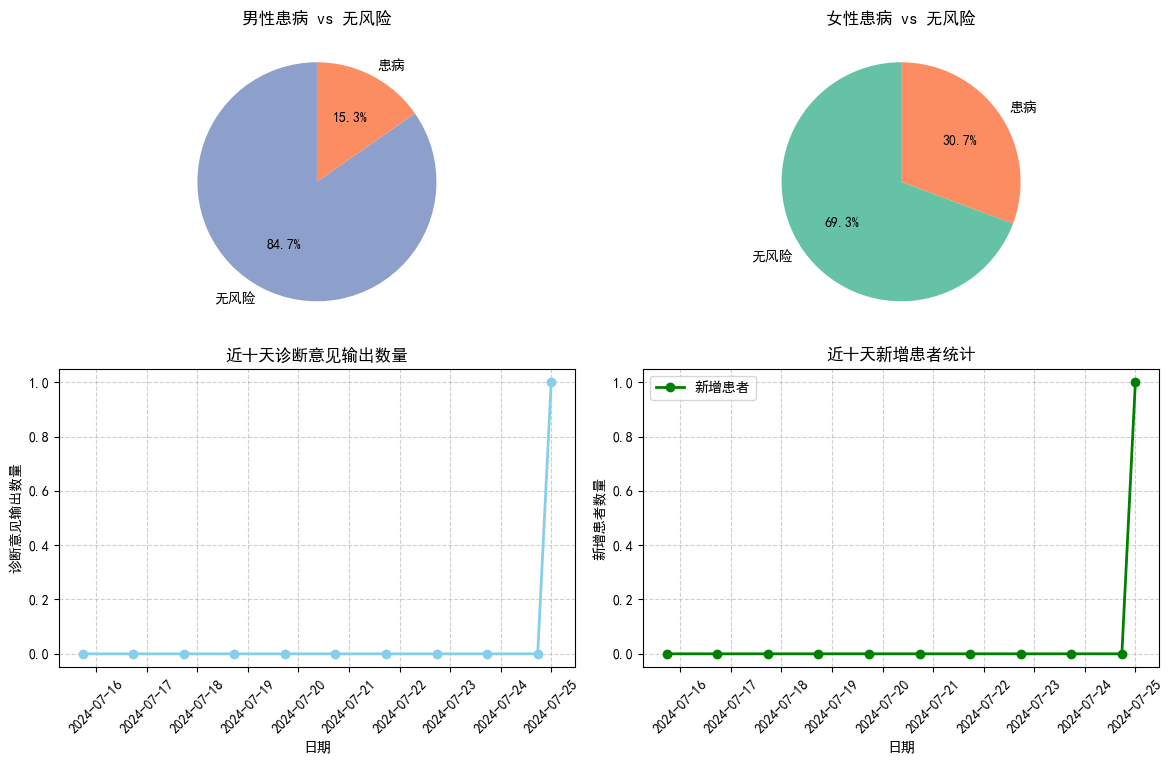

In [1]:
import sys
import pandas as pd
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *
from PyQt5.QtGui import *
import pickle
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
import pymysql
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import datetime

with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

class Database:
    def __init__(self):
        self.connection = pymysql.connect(
            host='localhost',  # 数据库地址
            user='root',       # 数据库用户名
            password='123456',       # 数据库密码
            database='heart_disease_prediction',  # 数据库名称
            charset='utf8mb4',
            cursorclass=pymysql.cursors.DictCursor
        )

    def close(self):
        self.connection.close()

    def execute(self, query, args=None):
        with self.connection.cursor() as cursor:
            cursor.execute(query, args)
            self.connection.commit()

    def fetchall(self, query, args=None):
        with self.connection.cursor() as cursor:
            cursor.execute(query, args)
            return cursor.fetchall()

class LoginDialog(QDialog):
    def __init__(self, parent=None):
        super(LoginDialog, self).__init__(parent)
        self.db = Database()
        self.setWindowTitle('登录页面')
        self.setGeometry(100, 50, 300, 100)
        self.setFixedSize(800, 600)  # Adjusted size for better appearance

        self.background_label = QLabel(self)
        self.background_label.setGeometry(0, 0, 800, 600)  # 调整标签大小以覆盖整个窗口
        pixmap = QPixmap('beijng.jpg')  # 替换为你的图片路径
        self.background_label.setPixmap(pixmap)
        self.background_label.setScaledContents(True)  # 让图片适应标签大小
        self.background_label.lower()
#         self.setStyleSheet("""
#             QWidget {
#                 background-image: url('beijng.jpg');
#                 background-repeat: no-repeat;
#                 background-position: center;
#                 background-attachment: fixed;
#             }

#             """)
        # Main layout
        centralLayout = QVBoxLayout(self)

        # Title label
        titleLabel = QLabel("基于多模型融合的心脏病风险预测系统")
        titleLabel.setAlignment(Qt.AlignCenter)
        titleLabel.setStyleSheet("font-size: 28px; font-weight: bold;")
        centralLayout.addWidget(titleLabel)

        # Form layout for username and password
        formLayout = QFormLayout()

        # Username and password fields
        self.username = QLineEdit(self)
        self.username.setFixedSize(300, 40)  # Larger and more readable
        self.password = QLineEdit(self)
        self.password.setFixedSize(300, 40)  # Consistent with username field
        self.password.setEchoMode(QLineEdit.Password)

        # Login button
        login_button = QPushButton('登录', self)
        login_button.setFixedSize(150, 40)  # Properly sized button
        login_button.setStyleSheet("QPushButton { color: white; background-color: #90EE90; border-radius: 6px; }"
                                        "QPushButton:hover { background-color: #77DD77; }"
                                        "QPushButton:pressed { background-color: #66CC66; }")

        # Add widgets to form layout
        formLayout.addRow("账号:", self.username)
        formLayout.addRow("密码:", self.password)

        # Add form layout to central layout
        centralLayout.addLayout(formLayout)
        centralLayout.addWidget(login_button, 0, Qt.AlignCenter)  # Center the button within the layout

        # Set form layout alignment and add spacing
        formLayout.setLabelAlignment(Qt.AlignRight)
        formLayout.setFormAlignment(Qt.AlignCenter)
        formLayout.setVerticalSpacing(20)

        # Connect the login button
        login_button.clicked.connect(self.handle_login)

    def handle_login(self):
        username = self.username.text()
        password = self.password.text()
        query = "SELECT * FROM manager WHERE username=%s AND password=%s"
        result = self.db.fetchall(query, (username, password))
        if result:
            self.accept()
        else:
            QMessageBox.warning(self, 'Error', '错误的账号或密码')

    def closeEvent(self, event):
        self.db.close()


class ChurnPredictionApp(QMainWindow):
    update_output1_signal = pyqtSignal(str)
    update_output2_signal = pyqtSignal(str)
    update_output3_signal = pyqtSignal(str)
    update_output4_signal = pyqtSignal(str)
    update_output5_signal = pyqtSignal(str)
    update_output6_signal = pyqtSignal(str)

    def __init__(self):
        super().__init__()
        self.db = Database()
        self.initUI()
        # 将QPalette应用于窗口
        self.update_output1_signal.connect(self.update_output1_slot)
        self.update_output2_signal.connect(self.update_output2_slot)
        self.update_output3_signal.connect(self.update_output3_slot)
        self.update_output4_signal.connect(self.update_output4_slot)
        self.update_output5_signal.connect(self.update_output5_slot)
        self.update_output6_signal.connect(self.update_output6_slot)
    def initUI(self):
        self.hide()
        # Login Dialog
        login = LoginDialog(self)
        if login.exec_() == QDialog.Accepted:
            self.setup_main_ui()
            self.show()
        else:
            self.close()  # Close the app if the login is not successful
            
    def setup_main_ui(self):
        self.centralwidget = QWidget()
        self.setCentralWidget(self.centralwidget)
        self.centralwidget = QWidget()
        self.setCentralWidget(self.centralwidget)
        self.Layout = QHBoxLayout(self.centralwidget)
        self.palette = QPalette()
        self.palette.setColor(QPalette.Background, QColor(255, 255, 255))
        self.centralwidget.setAutoFillBackground(True)
        self.centralwidget.setPalette(self.palette)

        # 设置五个个按钮
        self.topwidget = QWidget()
        self.palette = QPalette()
        self.palette.setColor(QPalette.Background, QColor(60,60,60)) # 设置背景色为RGB值为(128, 128, 128)的灰色
        self.topwidget.setAutoFillBackground(True)
        self.topwidget.setPalette(self.palette)

        self.buttonLayout = QVBoxLayout(self.topwidget)
        self.pushButton1 = QPushButton()
        self.pushButton1.setText("病症预测")
        self.pushButton1.setFixedSize(130, 50)  # 设置按钮大小
        self.pushButton1.setStyleSheet("QPushButton{background-color: rgb(60,60,60); color: white;font-size: 24px; font-weight: bold;}"
                    "QPushButton:hover{background:rgb(110,115,100);}"
                    "QPushButton::pressed{background:grey}")
        self.pushButton1.setIcon(QIcon("m1.png"))  # 设置按钮图标
        self.buttonLayout.addWidget(self.pushButton1)
       # self.pushButton1.setStyleSheet("background-color: red;")

        self.pushButton4 = QPushButton()
        self.pushButton4.setText("意见反馈")
        self.pushButton4.setFixedSize(130, 50)  # 设置按钮大小
        self.pushButton4.setStyleSheet(
            "QPushButton{background-color: rgb(60,60,60); color: white;font-size: 24px; font-weight: bold;}"
            "QPushButton:hover{background:rgb(110,115,100);}"  
            "QPushButton::pressed{background:grey;}" 
        )
        self.pushButton4.setIcon(QIcon("m2.png"))  # 设置按钮图标
        self.buttonLayout.addWidget(self.pushButton4)

        self.pushButton5 = QPushButton()
        self.pushButton5.setText("患者管理")
        self.pushButton5.setFixedSize(130, 50)  # 设置按钮大小
        self.pushButton5.setStyleSheet(
            "QPushButton{background-color: rgb(60,60,60); color: white;font-size: 24px; font-weight: bold;}"
            "QPushButton:hover{background:rgb(110,115,100);}" 
            "QPushButton::pressed{background:grey;}" 
        )
        self.pushButton5.setIcon(QIcon("m3.png"))  # 设置按钮图标
        self.buttonLayout.addWidget(self.pushButton5)
        
        self.pushButton6 = QPushButton()
        self.pushButton6.setText("数据可视")
        self.pushButton6.setFixedSize(130, 50)  # 设置按钮大小
        self.pushButton6.setStyleSheet(
            "QPushButton{background-color: rgb(60,60,60); color: white;font-size: 24px; font-weight: bold;}"
            "QPushButton:hover{background:rgb(110,115,100);}" 
            "QPushButton::pressed{background:grey;}" 
        )
        self.pushButton6.setIcon(QIcon("m4.png"))  # 设置按钮图标
        self.buttonLayout.addWidget(self.pushButton6)

        self.Layout.addWidget(self.topwidget)
        self.stackedWidget = QStackedWidget()
        self.Layout.addWidget(self.stackedWidget)

        self.setWindowTitle('基于多模型融合的心脏病风险预测系统')
        self.setGeometry(100, 50, 300, 100)
        self.setFixedSize(1400, 965)
        self.pdf_input_text=''
        self.log_result={}
        
        self.neicun = []
        
        # 设置第一个面板
        self.form1 = QWidget()
        self.background_label = QLabel(self.form1)
        self.background_label.setGeometry(0, 0, 1400, 965)  # 调整标签大小以覆盖整个窗口
        pixmap = QPixmap('beijng.jpg')  # 替换为你的图片路径
        self.background_label.setPixmap(pixmap)
        self.background_label.setScaledContents(True)  # 让图片适应标签大小
        self.background_label.lower()  # 将背景标签置于最底层
        self.layout = QVBoxLayout(self.form1)
    
        self.label2 = QLabel()
        self.label2.setText("基于多模型融合的心脏病风险预测系统")
        self.label2.setContentsMargins(15, 15, 15, 15)
        self.label2.setSizePolicy(QSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed))
        self.label2.setAlignment(Qt.AlignCenter)
        self.label2.setFont(QFont("STKaiti", 25, QFont.Bold))
        
        self.model = loaded_model
        self.loaded_file_label = QLabel("", self)
        self.loaded_file_label.setStyleSheet("font-size: 22px; color: red;font-weight: bold;")
        self.person_information = QLabel("", self)
        self.person_information.setStyleSheet("font-size: 22px; color: black;font-weight: bold;")
        self.comboBox = QComboBox(self)
        self.comboBox.currentIndexChanged.connect(self.update_display)
        self.label_result = QLabel("预测结果: ", self) 
        self.label_result.setStyleSheet("font-size: 26px; color: red;font-weight: bold;")
        self.button_load = QPushButton("加载Excel文件", self)
        self.button_load.setStyleSheet("font-size: 22px; color: black;font-weight: bold;background-color: #ADD8E6;")
        self.button_load.clicked.connect(self.load_excel)
        self.horizontal_layout = QHBoxLayout()
        self.form_layout_left = QFormLayout()
        self.form_layout_right = QFormLayout()

        self.horizontal_layout.addLayout(self.form_layout_left)
        self.horizontal_layout.addLayout(self.form_layout_right)
        self.layout.addWidget(self.label2)
        self.layout.addWidget(self.comboBox)
        self.layout.addWidget(self.button_load)
        self.layout.addWidget(self.loaded_file_label)
        self.layout.addWidget(self.person_information)
        self.layout.addLayout(self.horizontal_layout)
        self.layout.addWidget(self.label_result)

        # 设置第四个面板
        self.form4 = QWidget()
        self.background_label = QLabel(self.form4)
        self.background_label.setGeometry(0, 0, 1400, 965)  # 调整标签大小以覆盖整个窗口
        pixmap = QPixmap('beijng.jpg')  # 替换为你的图片路径
        self.background_label.setPixmap(pixmap)
        self.background_label.setScaledContents(True)  # 让图片适应标签大小
        self.background_label.lower()  # 将背景标签置于最底层
        self.layout4 = QVBoxLayout(self.form4)

        self.label5 = QLabel()
        self.label5.setText("基于多模型融合的心脏病风险预测系统")
        self.label5.setContentsMargins(15, 15, 15, 15)
        self.label5.setSizePolicy(QSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed))
        self.label5.setAlignment(Qt.AlignCenter)
        self.label5.setFont(QFont("STKaiti", 25, QFont.Bold))
        
        self.layout4.addWidget(self.label5)
        # 用户姓名输入
        self.name_layout = QHBoxLayout()

        self.name_label = QLabel("患者姓名:")
        self.name_label.setStyleSheet("font-size: 24px; color: black;")
        self.name_entry = QLineEdit()
        self.name_entry.setPlaceholderText("请输入您的姓名")
        self.name_entry.setStyleSheet("font-size: 24px; color: black;")
        self.name_layout.addWidget(self.name_label)
        self.name_layout.addWidget(self.name_entry)

        self.layout4.addLayout(self.name_layout)

        # 反馈内容输入
        self.feedback_layout = QVBoxLayout()

        self.feedback_label = QLabel("诊断意见:")
        self.feedback_label.setStyleSheet("font-size: 24px; color: black;")
        self.feedback_entry = QTextEdit()
        self.feedback_entry.setPlaceholderText("请输入您的反馈内容")
        self.feedback_entry.setStyleSheet("font-size: 24px; color: black;")
        self.feedback_layout.addWidget(self.feedback_label)
        self.feedback_layout.addWidget(self.feedback_entry)

        self.layout4.addLayout(self.feedback_layout)

        # 提交按钮
        self.submit_button = QPushButton("提交反馈")
        self.submit_button.setStyleSheet("")
        self.submit_button.setStyleSheet("""
            font-size: 26px;
            color: white;
            background-color: lightgreen;
            border-radius: 10px;
            padding: 10px;
        """)
        self.submit_button.clicked.connect(self.submit_feedback)
        self.layout4.addWidget(self.submit_button)
        
        # 设置第五个面板
        self.form5 = QWidget()
        self.background_label = QLabel(self.form5)
        self.background_label.setGeometry(0, 0, 1400, 965)  # 调整标签大小以覆盖整个窗口
        pixmap = QPixmap('beijng.jpg')  # 替换为你的图片路径
        self.background_label.setPixmap(pixmap)
        self.background_label.setScaledContents(True)  # 让图片适应标签大小
        self.background_label.lower()  # 将背景标签置于最底层
        self.layout5 = QVBoxLayout(self.form5)

        self.label6 = QLabel()
        self.label6.setText("基于多模型融合的心脏病风险预测系统")
        self.label6.setContentsMargins(15, 15, 15, 15)
        self.label6.setSizePolicy(QSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed))
        self.label6.setAlignment(Qt.AlignCenter)
        self.label6.setFont(QFont("STKaiti", 25, QFont.Bold))
        self.layout5.addWidget(self.label6)

        # 创建用户列表
        self.user_table = QTableWidget(self)
        self.user_table.setColumnCount(5)  # 增加列数
        self.user_table.setHorizontalHeaderLabels(["患者ID", "患者姓名", "年龄", "性别", "症状"])
        # 设置表格的样式表以调整字体大小
        self.user_table.setStyleSheet("QTableWidget {font-size: 20px;}")

        # 设置列宽
        self.user_table.setColumnWidth(0, 100)  # 用户ID的列宽
        self.user_table.setColumnWidth(1, 200) # 用户名的列宽
        self.user_table.setColumnWidth(2, 100)  # 年龄的列宽
        self.user_table.setColumnWidth(3, 100)  # 性别的列宽
        self.user_table.setColumnWidth(4, 500) # 症状的列宽

#         self.populate_user_table(users)
        self.populate_user_table()
        self.layout5.addWidget(self.user_table)

        # 添加用户的部分
        self.add_user_layout = QHBoxLayout()

        self.add_user_label = QLabel("患者姓名:")
        self.add_user_label.setStyleSheet("font-size: 22px; color: black;")
        self.add_user_entry = QLineEdit()
        self.add_user_entry.setStyleSheet("font-size: 22px; color: black;")
        self.add_user_age_label = QLabel("年龄:")
        self.add_user_age_label.setStyleSheet("font-size: 22px; color: black;")
        self.add_user_age_entry = QLineEdit()
        self.add_user_age_entry.setStyleSheet("font-size: 22px; color: black;")
        self.add_user_gender_label = QLabel("性别:")
        self.add_user_gender_label.setStyleSheet("font-size: 22px; color: black;")
        self.add_user_gender_entry = QLineEdit()
        self.add_user_gender_entry.setStyleSheet("font-size: 22px; color: black;")
        self.add_user_symptoms_label = QLabel("症状:")
        self.add_user_symptoms_label.setStyleSheet("font-size: 22px; color: black;")
        self.add_user_symptoms_entry = QLineEdit()
        self.add_user_symptoms_entry.setStyleSheet("font-size: 22px; color: black;")

        self.add_user_button = QPushButton("添加患者")
        self.add_user_button.setStyleSheet("font-size: 22px; color: white; background-color: #ADD8E6;font-weight: bold;")
        self.add_user_button.clicked.connect(self.add_user)

        self.add_user_layout.addWidget(self.add_user_label)
        self.add_user_layout.addWidget(self.add_user_entry)
        self.add_user_layout.addWidget(self.add_user_age_label)
        self.add_user_layout.addWidget(self.add_user_age_entry)
        self.add_user_layout.addWidget(self.add_user_gender_label)
        self.add_user_layout.addWidget(self.add_user_gender_entry)
        self.add_user_layout.addWidget(self.add_user_symptoms_label)
        self.add_user_layout.addWidget(self.add_user_symptoms_entry)
        self.add_user_layout.addWidget(self.add_user_button)

        self.layout5.addLayout(self.add_user_layout)

        # 删除用户的部分
        self.delete_user_layout = QHBoxLayout()

        self.delete_user_label = QLabel("患者ID:")
        self.delete_user_label.setStyleSheet("font-size: 22px; color: black;")
        self.delete_user_entry = QLineEdit()
        self.delete_user_entry.setStyleSheet("font-size: 22px; color: black;")
        self.delete_user_button = QPushButton("删除患者")
        self.delete_user_button.setStyleSheet("font-size: 22px; color: white; background-color: #FF0000;font-weight: bold;")
        self.delete_user_button.clicked.connect(self.delete_user)

        self.delete_user_layout.addWidget(self.delete_user_label)
        self.delete_user_layout.addWidget(self.delete_user_entry)
        self.delete_user_layout.addWidget(self.delete_user_button)

        self.layout5.addLayout(self.delete_user_layout)
        
            # 修改用户的部分
        self.modify_user_layout = QHBoxLayout()

        self.modify_user_id_label = QLabel("患者ID:")
        self.modify_user_id_label.setStyleSheet("font-size: 22px; color: black;")
        self.modify_user_id_entry = QLineEdit()
        self.modify_user_id_entry.setStyleSheet("font-size: 22px; color: black;")

        self.modify_user_name_label = QLabel("患者姓名:")
        self.modify_user_name_label.setStyleSheet("font-size: 22px; color: black;")
        self.modify_user_name_entry = QLineEdit()
        self.modify_user_name_entry.setStyleSheet("font-size: 22px; color: black;")

        self.modify_user_age_label = QLabel("年龄:")
        self.modify_user_age_label.setStyleSheet("font-size: 22px; color: black;")
        self.modify_user_age_entry = QLineEdit()
        self.modify_user_age_entry.setStyleSheet("font-size: 22px; color: black;")

        self.modify_user_gender_label = QLabel("性别:")
        self.modify_user_gender_label.setStyleSheet("font-size: 22px; color: black;")
        self.modify_user_gender_entry = QLineEdit()
        self.modify_user_gender_entry.setStyleSheet("font-size: 22px; color: black;")

        self.modify_user_symptoms_label = QLabel("症状:")
        self.modify_user_symptoms_label.setStyleSheet("font-size: 22px; color: black;")
        self.modify_user_symptoms_entry = QLineEdit()
        self.modify_user_symptoms_entry.setStyleSheet("font-size: 22px; color: black;")

        self.modify_user_button = QPushButton("修改患者")
        self.modify_user_button.setStyleSheet("font-size: 22px; color: white; background-color: #90EE90;font-weight: bold;")
        self.modify_user_button.clicked.connect(self.modify_user)

        self.modify_user_layout.addWidget(self.modify_user_id_label)
        self.modify_user_layout.addWidget(self.modify_user_id_entry)
        self.modify_user_layout.addWidget(self.modify_user_name_label)
        self.modify_user_layout.addWidget(self.modify_user_name_entry)
        self.modify_user_layout.addWidget(self.modify_user_age_label)
        self.modify_user_layout.addWidget(self.modify_user_age_entry)
        self.modify_user_layout.addWidget(self.modify_user_gender_label)
        self.modify_user_layout.addWidget(self.modify_user_gender_entry)
        self.modify_user_layout.addWidget(self.modify_user_symptoms_label)
        self.modify_user_layout.addWidget(self.modify_user_symptoms_entry)
        self.modify_user_layout.addWidget(self.modify_user_button)

        self.layout5.addLayout(self.modify_user_layout)
        
        # 设置第五个面板
        self.form6 = QWidget()
        self.background_label = QLabel(self.form6)
        self.background_label.setGeometry(0, 0, 1400, 965)  # 调整标签大小以覆盖整个窗口
        pixmap = QPixmap('beijng.jpg')  # 替换为你的图片路径
        self.background_label.setPixmap(pixmap)
        self.background_label.setScaledContents(True)  # 让图片适应标签大小
        self.background_label.lower()  # 将背景标签置于最底层
        self.layout6 = QVBoxLayout(self.form6)

        self.label7 = QLabel()
        self.label7.setText("基于多模型融合的心脏病风险预测系统")
        self.label7.setContentsMargins(15, 15, 15, 15)
        self.label7.setSizePolicy(QSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed))
        self.label7.setAlignment(Qt.AlignCenter)
        self.label7.setFont(QFont("STKaiti", 25, QFont.Bold))
        self.layout6.addWidget(self.label7)
        
        self.plot_button = QPushButton("更新数据可视化")
        self.plot_button.setStyleSheet("font-size: 22px; color: white; background-color: #ADD8E6;font-weight: bold;")
        self.plot_button.clicked.connect(self.update_plots)
        self.layout6.addWidget(self.plot_button)

        self.figure = plt.figure()
        self.canvas = FigureCanvas(self.figure)
        self.layout6.addWidget(self.canvas)
        
        # 将三个面板，加入stackedWidget
        self.stackedWidget.addWidget(self.form1)
        self.stackedWidget.addWidget(self.form4)
        self.stackedWidget.addWidget(self.form5)
        self.stackedWidget.addWidget(self.form6)
        ###### 三个按钮事件 ######
        self.pushButton1.clicked.connect(self.on_pushButton1_clicked)
        self.pushButton4.clicked.connect(self.on_pushButton4_clicked)
        self.pushButton5.clicked.connect(self.on_pushButton5_clicked)
        self.pushButton6.clicked.connect(self.on_pushButton6_clicked)
        plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
        plt.rcParams['font.sans-serif'] = ['SimHei'] 
        self.show()
    def modify_user(self):
        user_id = self.modify_user_id_entry.text()
        name = self.modify_user_name_entry.text()
        age = self.modify_user_age_entry.text()
        gender = self.modify_user_gender_entry.text()
        symptoms = self.modify_user_symptoms_entry.text()

        if not user_id:
            QMessageBox.warning(self, "输入错误", "患者ID不能为空！")
            return

        try:
            # 构建更新语句
            update_fields = []
            update_values = []

            if name:
                update_fields.append("name=%s")
                update_values.append(name)
            if age:
                update_fields.append("age=%s")
                update_values.append(age)
            if gender:
                update_fields.append("gender=%s")
                update_values.append(gender)
            if symptoms:
                update_fields.append("symptoms=%s")
                update_values.append(symptoms)

            if update_fields:
                update_values.append(user_id)  # 把 user_id 添加到参数列表的最后
                update_query = f"UPDATE users SET {', '.join(update_fields)} WHERE id=%s"
                self.db.execute(update_query, tuple(update_values))
                QMessageBox.information(self, "修改成功", "患者信息已成功修改。")
                self.populate_user_table()
            else:
                QMessageBox.warning(self, "输入错误", "至少要有一个字段进行修改！")

        except Exception as e:
            QMessageBox.critical(self, "修改失败", f"修改患者信息时发生错误: {e}")
        
    def load_excel(self):
        options = QFileDialog.Options()
        options |= QFileDialog.ReadOnly
        file_name, _ = QFileDialog.getOpenFileName(self, "选择Excel文件", "", "Excel Files (*.xlsx *.xls);;All Files (*)", options=options)

        if file_name:
            self.df = pd.read_excel(file_name)
            self.comboBox.clear()
            self.comboBox.addItems([str(index) for index in self.df.index])
            
            # Update the loaded file label
            self.loaded_file_label.setText(f"已加载文件：{file_name}")
            self.person_information.setText("患者具体信息：")

    def update_display(self): 
        self.neicun = []
        selected_index = int(self.comboBox.currentText())
        selected_row = self.df.loc[selected_index]

        self.clear_form_layouts()

        column_count = len(selected_row)
        middle_index = column_count // 2
        for i, (column, value) in enumerate(selected_row.iteritems()):
            label = QLabel(f"{column}:", self)
            data_label = QLabel(str(value), self)
            self.neicun.append(f"{column}:{value}")
            if i < middle_index:
                self.form_layout_left.addRow(label, data_label)
            else:
                self.form_layout_right.addRow(label, data_label)

        # Assume your model accepts the selected_row as features and returns a binary classification result
        prediction = self.model.predict([selected_row])[0]

        self.label_result.setText(f"预测结果: {'疑似有心脏病，具体请遵循医生意见！' if prediction >= 0.5 else '智能预测无心脏病风险，'}预测心脏病概率为：{prediction*100}%")
    
    def submit_feedback(self):
        name = self.name_entry.text()
        feedback = self.feedback_entry.toPlainText()

        if not name or not feedback:
            QMessageBox.warning(self, "输入错误", "姓名和反馈内容不能为空！")
            return
        
        doc = Document()
        doc.add_heading('诊断意见反馈文档', level=0)

        doc.add_heading('患者姓名:', level=1)
        doc.add_paragraph(name)

        doc.add_heading('指标数据:', level=1)
        if self.neicun!='':
            table = doc.add_table(rows=1, cols=2)
            table.style = 'Table Grid'  # 添加网格风格
            hdr_cells = table.rows[0].cells
            hdr_cells[0].text = '第一列'
            hdr_cells[1].text = '第二列'
            count = 0
            for item in self.neicun:
                if count == 0:
                    row_cells = table.add_row().cells
                row_cells[count].text = item
                count+=1
                count%=2
        else:
            doc.add_paragraph("无检测指标结果。")
        
        doc.add_heading('模型预测结果:', level=1)
        doc.add_paragraph(self.label_result.text())
        
        doc.add_heading('诊断意见:', level=1)
        doc.add_paragraph(feedback)

        # 保存文档
        file_path = f"{name}_意见.docx"
        doc.save(file_path)
        # 将数据插入到 diagnosis 表
        self.db.execute("INSERT INTO diagnosis (patient_name, feedback, date) VALUES (%s, %s, %s)",
                        (name, feedback, datetime.datetime.now()))
        # 通知用户文档已保存
        QMessageBox.information(self, "提交成功", f"您的反馈已保存至文档：{file_path}")
        
    def clear_form_layouts(self):
        self.clear_layout(self.form_layout_left)
        self.clear_layout(self.form_layout_right)

    def clear_layout(self, layout):
        for i in reversed(range(layout.count())):
            layout.itemAt(i).widget().setParent(None)
    def calculate(self):
        pass
    def update_output1(self):
        pass
    def generate_input_value1(self):
        pass
    # 定义一个槽函数，用于处理信号
    def update_output1_slot(self, input_value):
        pass
    def page2_button(self):
        pass
    def update_output2(self):
        pass
    def generate_input_value2(self):
        pass
    # 定义一个槽函数，用于处理信号
    def update_output2_slot(self, input_value):
        pass
    def page3_button(self):
        pass
    def update_output3(self):
        pass
    def generate_input_value3(self):
        pass
    # 定义一个槽函数，用于处理信号
    def update_output3_slot(self, input_value):
        pass
    def page4_button(self):
        pass
    def update_output4(self):
        pass
    def generate_input_value4(self):
        pass
    # 定义一个槽函数，用于处理信号
    def update_output4_slot(self, input_value):
        pass
    def page5_button(self):
        pass
    def update_output5(self):
        pass
    def generate_input_value5(self):
        pass
    # 定义一个槽函数，用于处理信号
    def update_output5_slot(self, input_value):
        pass
    def page6_button(self):
        pass
    def update_output6(self):
        pass
    def generate_input_value6(self):
        pass
    # 定义一个槽函数，用于处理信号
    def update_output6_slot(self, input_value):
        pass
    def on_pushButton1_clicked(self):
        self.stackedWidget.setCurrentIndex(0)
    def on_pushButton4_clicked(self):
        self.stackedWidget.setCurrentIndex(1)
    def on_pushButton5_clicked(self):
        self.stackedWidget.setCurrentIndex(2)
    def on_pushButton6_clicked(self):
        self.stackedWidget.setCurrentIndex(3)

    def update_plots(self):
        self.figure.clear()

        if hasattr(self, 'df'):
            # 第一类数据可视化：病症预测结果
            self.plot_disease_prediction()

        # 第二类数据可视化：诊断意见输出数量
        self.plot_diagnosis_outputs()

        # 第三类数据可视化：患者管理统计
        self.plot_patient_management()

        self.canvas.draw()

    def plot_disease_prediction(self):
        df = self.df.copy()
        df['prediction'] = self.model.predict(df)
        df['prediction'] = df['prediction'].apply(lambda x: '患病' if x >= 0.5 else '无风险')

        male = df[df['Gender'] == 0]['prediction'].value_counts()
        female = df[df['Gender'] == 1]['prediction'].value_counts()

        colors = ['#8da0cb', '#fc8d62']

        ax2 = self.figure.add_subplot(221)
        ax2.pie(male, labels=male.index, autopct='%1.1f%%', startangle=90, colors=colors)
        ax2.set_title('男性患病 vs 无风险')
        
        colors = ['#66c2a5', '#fc8d62']
        ax3 = self.figure.add_subplot(222)
        ax3.pie(female, labels=female.index, autopct='%1.1f%%', startangle=90, colors=colors)
        ax3.set_title('女性患病 vs 无风险')

    def plot_diagnosis_outputs(self):
        # Get today's date and the date 15 days ago
        today = datetime.datetime.now()
        start_date = today - datetime.timedelta(days=10)

        # Fetch data for the past 10 days
        query = """
        SELECT DATE(date) as diagnosis_date, COUNT(*) as count 
        FROM diagnosis 
        WHERE date >= %s AND date <= %s
        GROUP BY diagnosis_date
        ORDER BY diagnosis_date
        """
        outputs = self.db.fetchall(query, (start_date, today))

        # Create a dictionary to store counts for each date
        date_counts = {start_date + datetime.timedelta(days=i): 0 for i in range(10)}
        for row in outputs:
            date_counts[row['diagnosis_date']] = row['count']

        # Extract dates and counts for plotting
        dates = list(date_counts.keys())
        counts = list(date_counts.values())

        # Plotting the line chart in the specified subplot
        ax = self.figure.add_subplot(223)
        ax.plot(dates, counts, marker='o', linestyle='-', color='skyblue', linewidth=2, markersize=6)

        # Formatting the plot for better aesthetics
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlabel('日期')
        ax.set_ylabel('诊断意见输出数量')
        ax.set_title('近十天诊断意见输出数量')
        ax.grid(True, linestyle='--', alpha=0.6)

        # Adjust layout for better fit
        self.figure.tight_layout()

    def plot_patient_management(self):
        # Get today's date and the date 15 days ago
        today = datetime.datetime.now()
        start_date = today - datetime.timedelta(days=10)

        new_patients_query = """
        SELECT DATE(created_at) as action_date, COUNT(*) as count 
        FROM users 
        WHERE created_at >= %s AND created_at <= %s
        GROUP BY action_date
        ORDER BY action_date
        """
        new_patients = self.db.fetchall(new_patients_query, (start_date, today))

        # Create a dictionary to store counts for each date
        date_counts_new = {start_date + datetime.timedelta(days=i): 0 for i in range(10)}

        for row in new_patients:
            date_counts_new[row['action_date']] = row['count']

        # Extract dates and counts for plotting
        dates = list(date_counts_new.keys())
        new_counts = list(date_counts_new.values())

        # Plotting the line chart in the specified subplot
        ax = self.figure.add_subplot(224)
        ax.plot(dates, new_counts, marker='o', linestyle='-', color='green', linewidth=2, markersize=6, label='新增患者')

        # Formatting the plot for better aesthetics
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlabel('日期')
        ax.set_ylabel('新增患者数量')
        ax.set_title('近十天新增患者统计')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()

        # Adjust layout for better fit
        self.figure.tight_layout()
        
        
    def populate_user_table(self):
        users = self.db.fetchall("SELECT * FROM users")  # 每页显示20条记录
        self.user_table.setRowCount(len(users))
        for row, user in enumerate(users):
            self.user_table.setItem(row, 0, QTableWidgetItem(str(user["id"])))
            self.user_table.setItem(row, 1, QTableWidgetItem(user["name"]))
            self.user_table.setItem(row, 2, QTableWidgetItem(str(user["age"])))
            self.user_table.setItem(row, 3, QTableWidgetItem(user["gender"]))
            self.user_table.setItem(row, 4, QTableWidgetItem(user["symptoms"]))

    def add_user(self):
        username = self.add_user_entry.text()
        age = self.add_user_age_entry.text()
        gender = self.add_user_gender_entry.text()
        symptoms = self.add_user_symptoms_entry.text()
        self.db.execute("INSERT INTO users (name, age, gender, symptoms) VALUES (%s, %s, %s, %s)", (username, age, gender, symptoms))
        self.populate_user_table()

    def delete_user(self):
        user_id = int(self.delete_user_entry.text())
        self.db.execute("DELETE FROM users WHERE id = %s", (user_id,))
        self.populate_user_table()

app = QApplication(sys.argv)
font = QFont("STFangsong")
app.setFont(font)
window = ChurnPredictionApp()
sys.exit(app.exec_())